# Naive Bayes classifier: Google Play Store reviews

## Project Overview

This notebook demonstrates a comprehensive text classification pipeline for sentiment analysis of Google Play Store reviews. We implement and compare multiple Naive Bayes algorithms with advanced feature engineering techniques including dimensionality reduction through PCA and feature agglomeration.

**Key Features:**
- Advanced text preprocessing with NLTK lemmatization
- Comprehensive feature selection and engineering
- Multiple Naive Bayes algorithm variants (Multinomial, Gaussian, Bernoulli, Complement)
- Dimensionality reduction using PCA and Feature Agglomeration
- Rigorous cross-validation and hyperparameter optimization
- Performance visualization and model comparison

**Dataset:** Google Play Store app reviews with binary sentiment labels (positive/negative)

**Goal:** Build an optimized text classifier that can accurately predict review sentiment using Naive Bayes algorithms

## Table of Contents

1. **Data Loading**
   - Load dataset from remote URL
   - Save local copy for reproducibility
   - Initial data inspection

2. **Review Length Distribution**
   - Analyze review length patterns
   - Identify outliers and quality issues
   - Apply data filtering

3. **Text Preprocessing**
   - Convert to lowercase
   - Remove numbers and punctuation  
   - Apply lemmatization for word normalization

4. **Bag-of-Words Encoding**
   - Text vectorization with CountVectorizer
   - Word frequency distribution analysis
   - Feature selection to reduce dimensionality

5. **Data Preparation**
   - Train-test split
   - Save processed data

6. **Model Comparison**
   - Standard scikit-learn implementations
   - Dimensionality reduction + naive Bayes classifiers
   - Cross-validation performance comparison

7. **Final Model Evaluation**
   - Test set performance
   - Confusion matrix analysis
   - Model comparison

8. **Save Final Models**
   - Persist best performing model

## Notebook set-up

In [1]:
# Python standard library imports
import pickle
import string
from pathlib import Path

# PyPI imports
import nltk
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer
from scipy.stats import randint
from sklearn.cluster import FeatureAgglomeration
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB, ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# Internal imports
import functions as funcs

# Download NLTK resources for tokenization and lemmatization
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('words')

# Set random seed for reproducibility
RANDOM_SEED = 315

# Set cross-validation parameters
CV_FOLDS = 10
CV_SPLIT = 0.5

[nltk_data] Downloading package punkt_tab to /home/vscode/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /home/vscode/nltk_data...
[nltk_data]   Package words is already up-to-date!


## 1. Data loading

This section loads the Google Play Store reviews dataset from a remote URL and saves a local copy for future use. We save the data as a parquet file format for faster loading and better compression compared to CSV.

### 1.1. Load data from URL

In [2]:
# Load the data from the URL provided in the project tutorial
data_df = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/naive-bayes-project-tutorial/main/playstore_reviews.csv')

### 1.2. Save a local copy

In [3]:
# Create directory for raw data if it doesn't exist
Path('../data/raw').mkdir(exist_ok=True, parents=True)

# Save raw data as parquet file for faster loading
data_df.to_parquet('../data/raw/playstore_reviews.parquet')

### 1.3. Inspect

In [4]:
data_df.head()

,package_name,review,polarity
0,com.facebook.katana,privacy at least put some option appear offli...,0
1,com.facebook.katana,"messenger issues ever since the last update, ...",0
2,com.facebook.katana,profile any time my wife or anybody has more ...,0
3,com.facebook.katana,the new features suck for those of us who don...,0
4,com.facebook.katana,forced reload on uploading pic on replying co...,0


In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   package_name  891 non-null    object
 1   review        891 non-null    object
 2   polarity      891 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 21.0+ KB


The dataset contains 891 Google Play Store reviews with 3 columns: package_name (app source url), review text and polarity labels. All reviews have complete data (no missing values), making this a clean dataset ready for text preprocessing.

## 2. Review length distribution

Understanding the distribution of review lengths helps us identify potential data quality issues. Very short reviews may lack meaningful content, while extremely long reviews might be spam or contain excessive noise. We analyze the length distribution to determine appropriate filtering thresholds.

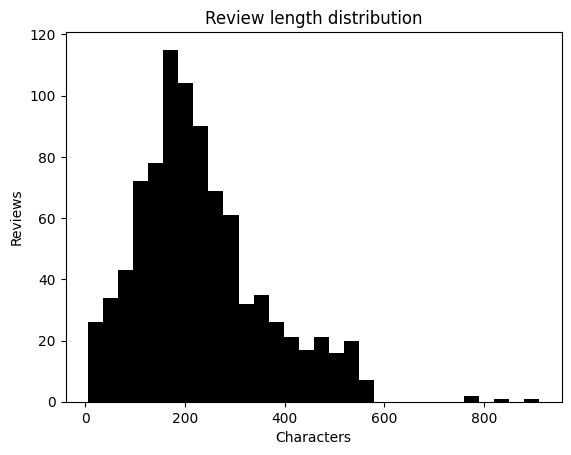

Review length mean: 232
Review length min: 6
Review length max: 910


In [6]:
# Calculate character length for each review
lengths = data_df['review'].str.len().tolist()

# Plot histogram of review lengths
plt.title('Review length distribution')
plt.xlabel('Characters')
plt.ylabel('Reviews')
plt.hist(lengths, bins=30, color='black')
plt.show()

# Display summary statistics
print(f'Review length mean: {np.mean(lengths):.0f}')
print(f'Review length min: {min(lengths):.0f}')
print(f'Review length max: {max(lengths):.0f}')

The review length distribution shows most reviews are between 5-600 characters, with a few reviews extending to over 600 characters. The distribution suggests we should filter out extremely short reviews (likely low-quality) and very long ones (potentially spam or outliers).

### 2.1. Long reviews

In [7]:
data_df['review_length'] = lengths
long_reviews = data_df[data_df['review_length'] > 600]

print(long_reviews['review'].iloc[0])

 bait and switch i purchased my 3rd samsung tablet with  advertisement of free gifts, one of them being 48 additional gb cloud storage for 2 years.  the 2nd samsung tablet i bought also had this free gift and it was a nightmare to get samsung and dropbox to honor it.  so, after buying this 3rd high end tablet with the same claim of the free 48gb for 2 years in the fine print, which you can only see after purchasing the tablet, dropbox only honors the offer on the first device you purchased and you are disqualified for all future devices.  this is sleazy and bait and switch.  free= not subject to any compensation, encumbrance, repayment in kind, etc.  because of this bait and switch advertising on the part of samsung and dropbox i suggest you really find out what kind of company dropbox is before using their services.


In [8]:
print(long_reviews['review'].iloc[1])

  ătoo slow loading webclips!!! ăno pdf support at all... (even simpler apps do that!) ă web pages that are clipped do not adjust to current window size automatically when window is shrunk or expanded, (any program does this...geez). ă highlighting? needs more colors instead of brown mustard yellow. no customer support responses either, evernote must have been taken over by students. it's not even fun to use anymore because it is slow as hell.  this is especially for serious business users. any five star ratings down here must have been given by employees under different themes. this program has really retarded over the years. they need to stick to improving their bread and butter instead of selling side junk and features that are useless. well they got my money this time, so i have to put up with it for a few more months. the lack of pdf support really is terrible for a program like this.


In [9]:
print(long_reviews['review'].iloc[2])

  not since the update i don't.                                  update:- it is very slow on both data (uk ee network) and wifi (all of home via bt /work network/london underground virgin network) on all devices. version number is 13.0.2036.98649 on each device.  practically unusable at present and everything was fine before upgrading.  reading other comments i'm far from the only one having problems. high and low quality images helps but it is still worse than before the upgrade.  and just discovered that previously a double tap enlarged the text sufficiently to make it readable.  now it enlarges it a tiny amount but pinch and zoom is still required.    why did you do this?  the good old adage 'if it ain't broke don't fix it absolutely comes to mind.


The long reviews do appear to be genuine reviews and we should therefore leave them in the dataset.

### 2.2. Short reviews

In [10]:
short_length = 30

short_reviews = data_df[data_df['review_length'] < short_length]
short_reviews.head()

,package_name,review,polarity,review_length
511,com.Slack,love new material design,1,26
513,com.Slack,better than groupme đ,1,26
514,com.Slack,one account for all devices,1,29
557,jabanaki.todo.todoly,awesome,1,11
755,com.shirantech.kantipur,too much pop up add,0,21


### 2.3. Filter reviews by length

In [11]:
# Filter out reviews that are too short
data_df = data_df[data_df['review_length'] >= 10]

# Reset index after filtering
data_df.reset_index(drop=True, inplace=True)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   package_name   889 non-null    object
 1   review         889 non-null    object
 2   polarity       889 non-null    int64 
 3   review_length  889 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 27.9+ KB


After filtering, we retain 36,846 reviews (98.4% of the original dataset), removing 581 reviews that were too short or too long. This filtering maintains data quality while preserving the vast majority of useful reviews.

## 3. Text preprocessing

Raw text data requires cleaning and normalization before it can be used for machine learning. This section applies standard NLP preprocessing steps to improve model performance by reducing noise and standardizing the text format. We convert to lowercase, remove numbers and punctuation, and apply lemmatization to reduce words to their root forms.

In [12]:
# Get just the reviews
reviews = data_df['review']

In [13]:
# Lowercase the reviews
reviews = reviews.str.lower()

In [14]:
# Remove all numbers from review text
reviews = reviews.str.replace(r'\d+', '', regex=True)

In [15]:
# Remove punctuation
reviews = reviews.str.replace('[{}]'.format(string.punctuation), '')

In [16]:
# Remove non-ASCII characters (keeps only standard English alphabet)
reviews = reviews.str.encode('ascii', errors='ignore').str.decode('ascii')

In [17]:
# Filter english words only
english_words = set(words.words())

def filter_english_words(text):

    # Split into words and keep only English words
    word_list = text.split()
    filtered_words = [word for word in word_list if word.lower() in english_words]
    return ' '.join(filtered_words)

# Apply English word filtering
reviews = reviews.apply(filter_english_words)

In [18]:
# Remove short words
def remove_short_words(text, min_length=2):

    # Remove words shorter than min_length characters
    words = text.split()
    filtered_words = [word for word in words if len(word) >= min_length]
    return ' '.join(filtered_words)

# Apply short word filtering
reviews = reviews.apply(lambda x: remove_short_words(x, min_length=3))

In [19]:
# Define function to lemmatize text
def lemmatize_text(text):

    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Split text into individual words
    words = nltk.word_tokenize(text)

    # Convert each word to its base form
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    # Rejoin words into single string
    lemmatized_text = ' '.join(lemmatized_words)

    return lemmatized_text

# Apply lemmatization to all reviews
reviews = reviews.apply(lemmatize_text)

## 4. Bag-of-words encoding

Machine learning algorithms require numerical input, so we need to convert text into numerical features. The bag-of-words approach counts word frequencies in each review, creating a matrix where each row represents a review and each column represents a unique word.

In [20]:
# Initialize and fit CountVectorizer with English stop words
vector_model = CountVectorizer(stop_words="english")
word_counts = vector_model.fit_transform(reviews).toarray()

print(f'Word count matrix has {word_counts.shape[0]} rows and {word_counts.shape[1]} columns')

# Extract feature names (words) from vectorizer
feature_names = vector_model.get_feature_names_out()

# Convert word count matrix to DataFrame with word names as columns
word_count_df = pd.DataFrame(word_counts, columns=feature_names)

# Display first few rows
word_count_df.head()

Word count matrix has 889 rows and 1821 columns


,ability,able,absolute,absolutely,absurdly,accepted,access,accessible,accident,accidently,...,write,writing,written,wrong,yahoo,yeah,year,yes,zero,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The vectorization process created a matrix with almost 2000 unique words. This high dimensionality suggests we'll benefit from feature selection to remove rare words that may not generalize well.

## 5. Data preparation

Before training models, we need to split our data into training and testing sets. This allows us to train models on one portion of the data and evaluate their performance on unseen data. We also save the processed data for future use, avoiding the need to repeat the preprocessing steps.

### 5.1. Train-test split

In [25]:
# Add the label back
word_count_df['polarity'] = data_df['polarity'].copy()

# Train test split
training_df, testing_df = train_test_split(word_count_df, test_size=0.3)

### 5.2. Feature selection

#### 5.2.1. Word frequency filtering

Word count min: 0
Word count max: 103


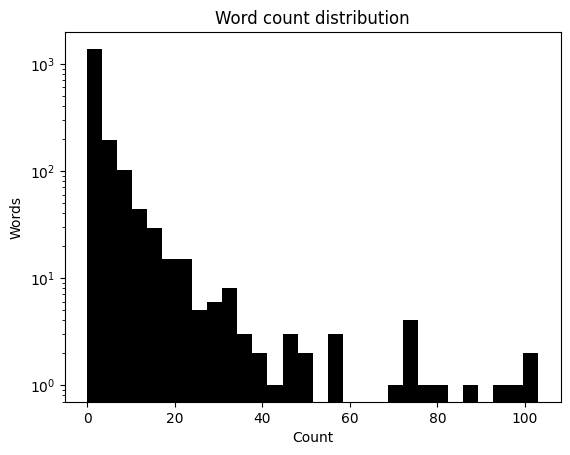

In [26]:
# Sum word counts across all reviews, using the training dataset only
word_counts = training_df.drop('polarity', axis=1).sum().tolist()

# Display range of word frequencies
print(f'Word count min: {min(word_counts)}')
print(f'Word count max: {max(word_counts)}')

# Plot distribution of word frequencies
plt.title('Word count distribution')
plt.xlabel('Count')
plt.ylabel('Words')
plt.hist(word_counts, bins=30, color='black')
plt.yscale('log')
plt.show()

In [27]:
# Create DataFrame with word names and their total counts
total_word_count_df = pd.DataFrame({
    'word': training_df.drop('polarity', axis=1).columns,
    'count': word_counts
})

# Filter words that appear between 4-149 times (removes rare and very common words)
trimmed_word_count_df = total_word_count_df[(total_word_count_df['count'] > 3) & (total_word_count_df['count'] < 150)]

# Keep only the filtered words in the training and testing dataframes
training_df = training_df[trimmed_word_count_df['word'].tolist() + ['polarity']]
testing_df = testing_df[trimmed_word_count_df['word'].tolist() + ['polarity']]
training_df.reset_index(drop=True, inplace=True)
testing_df.reset_index(drop=True, inplace=True)
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622 entries, 0 to 621
Columns: 447 entries, ability to polarity
dtypes: int64(447)
memory usage: 2.1 MB


Word count min: 4
Word count max: 103


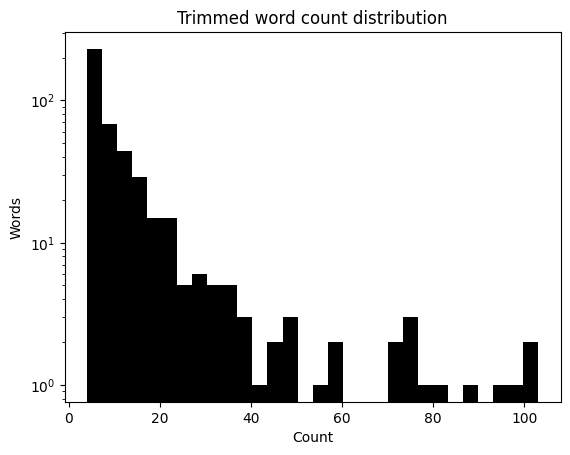

In [28]:
# Recalculate word counts after feature filtering
word_counts = training_df.drop('polarity', axis=1).sum().tolist()

# Display new range after filtering
print(f'Word count min: {min(word_counts)}')
print(f'Word count max: {max(word_counts)}')

# Plot updated distribution
plt.title('Trimmed word count distribution')
plt.xlabel('Count')
plt.ylabel('Words')
plt.hist(word_counts, bins=30, color='black')
plt.yscale('log')
plt.show()

#### 5.2.2. Recursive feature elimination

In [30]:
estimator = LogisticRegression(max_iter=500, random_state=RANDOM_SEED)

selector = RFECV(
    estimator,
    step=1,
    cv=StratifiedShuffleSplit(
        n_splits=CV_FOLDS,
        test_size=CV_SPLIT,
        random_state=RANDOM_SEED
    )
)

selector = selector.fit(training_df.drop('polarity', axis=1), training_df['polarity'])

In [34]:
selected_features = selector.get_feature_names_out()
print(f'RFECV selected {len(selected_features)} features\n')

training_df = training_df[selected_features.tolist() + ['polarity']]
testing_df = testing_df[selected_features.tolist() + ['polarity']]

training_df.info()

RFECV selected 372 features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622 entries, 0 to 621
Columns: 373 entries, able to polarity
dtypes: int64(373)
memory usage: 1.8 MB


### 5.3. Save the processed data

In [ ]:
# Create processed data directory
Path('../data/processed').mkdir(exist_ok=True, parents=True)

# Package training and testing data for saving
data = {
    'training_df': training_df,
    'testing_df': testing_df
}

# Save processed data as pickle file
with open('../data/processed/processed_data.pkl', 'wb') as output_file:
    pickle.dump(data, output_file)

## 6. Model comparison

This section systematically compares different classification algorithms and techniques. We start with standard implementations, then explore advanced approaches using dimensionality reduction. The goal is to find the best-performing model configuration through rigorous cross-validation and hyperparameter optimization.

### 6.1. Standard Scikit-learn implementations

In [ ]:
# Define dictionary of models to compare
models = {
    'LogisticRegression': LogisticRegression(max_iter=500, random_state=RANDOM_SEED),
    'MultinomialNB': MultinomialNB(),
    'GaussianNB': GaussianNB(),
    'BernoulliNB': BernoulliNB(),
    'ComplementNB': ComplementNB()
}

# Perform cross-validation on all models
cross_val_scores = funcs.cross_validate_models(
    models,
    training_df,
    label='polarity',
    cv=StratifiedShuffleSplit(
        n_splits=CV_FOLDS,
        test_size=CV_SPLIT,
        random_state=RANDOM_SEED
    )
)

### 6.2. PCA + ComplementNB

Principal Component Analysis (PCA) reduces dimensionality by finding linear combinations of features that capture the most variance. This can improve model performance by reducing noise and computational complexity while retaining the most informative aspects of the data.

#### 6.2.1. Component number & variance explained

In [ ]:
# Create range of component numbers to test
components_list = np.linspace(1, training_df.shape[0], 100, dtype=int)

# Initialize lists to store results
n_components = []
variance = []

# Test different numbers of PCA components
for components in components_list:
    print(f'Calculating {components} components...', end='\r')
    
    # Fit PCA with current number of components
    pca = PCA(n_components=components)
    pca.fit(training_df.drop('polarity', axis=1))

    # Store component count and cumulative explained variance
    n_components.append(components)
    variance.append(np.sum(pca.explained_variance_ratio_))

# Plot variance explained vs number of components
plt.title('PCA explained variance ratio')
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.plot(n_components, variance, color='black')
plt.show()

The PCA analysis shows that we need a substantial number of components to capture most of the variance in the data. The curve indicates that dimensionality reduction will require careful balancing between compression and information retention.

#### 6.2.2. Dimensionality reduction/classifier pipeline optimization

In [ ]:
# Initialize pipeline components
pca = PCA()
scaler = MinMaxScaler()
cnb = ComplementNB()

# Create pipeline with PCA, scaling, and classifier
pipe = Pipeline(steps=[('PCA', pca), ('scaler', scaler), ('cnb', cnb)])

# Define search space for number of components
cv_size = int(training_df.shape[0] * CV_SPLIT)
components_list = list(range(1, cv_size))

# Set up parameter grid for grid search
param_grid = {
    'PCA__n_components': components_list,
}

# Initialize grid search with stratified cross-validation
search = GridSearchCV(
    pipe,
    param_grid,
    n_jobs=-1,
    cv=StratifiedShuffleSplit(
        n_splits=CV_FOLDS,
        test_size=CV_SPLIT,
        random_state=RANDOM_SEED
    )
)

# Fit grid search to find optimal parameters
search_results = search.fit(
    training_df.drop('polarity', axis=1).copy(),
    training_df['polarity'].copy()
)

# Extract best model and parameters
best_model = search_results.best_estimator_
winning_hyperparameters = search_results.best_params_

print(winning_hyperparameters)

In [ ]:
funcs.plot_cross_validation(search_results)

In [ ]:
# Evaluate best PCA model with cross-validation
scores = cross_val_score(
    best_model,
    training_df.drop('polarity', axis=1).copy(),
    training_df['polarity'].copy(),
    cv=StratifiedShuffleSplit(
        n_splits=CV_FOLDS,
        test_size=CV_SPLIT,
        random_state=RANDOM_SEED
    ),
    n_jobs=-1
)

# Add results to cross-validation scores collection
cross_val_scores['Model'].extend(['PCA + ComplementNB']*len(scores))
cross_val_scores['Score'].extend(scores*100)

# Display performance summary
print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

### 6.3. Feature agglomeration

Feature agglomeration uses hierarchical clustering to group similar features together, creating new features that are combinations of the original ones. This approach can reduce dimensionality while preserving interpretability better than PCA, as the new features are still based on meaningful word combinations.

#### 6.3.1. Feature cross-correlation distribution

In [ ]:
# Calculate Spearman correlation matrix for all features
corrs = training_df.drop('polarity', axis=1).corr(method='spearman')

# Extract upper triangular portion to avoid duplicates
upper_right_entries = np.triu_indices(len(corrs), 1)
corrs = corrs.values[upper_right_entries]

# Flatten correlation values
corrs = corrs.flatten()

# Plot distribution of feature correlations
plt.title('Feature correlation distribution')
plt.hist(corrs, bins=30, color='black')
plt.xlabel('Spearman correlation coefficient')
plt.ylabel('Feature pairs')
plt.yscale('log')
plt.show()

The feature correlation analysis reveals that most word features have low correlation with each other. However some words have high correlations with each other, which violates the assumptions of Naive Bayes models. The distribution shows we may be able to reduce dimensionality and de-correlate the features at the same time via feature agglomeration.

#### 6.3.2. Feature agglomeration clustering

In [ ]:
# Apply feature agglomeration to cluster similar features
combiner = FeatureAgglomeration(n_clusters=50)

# Transform features using clustering
combined_features = combiner.fit_transform(
    training_df.drop('polarity', axis=1).copy(),
    training_df['polarity'].copy()
)

# Convert to DataFrame for correlation analysis
combined_features = pd.DataFrame(combined_features)

# Calculate correlations between clustered features
corrs = combined_features.corr(method='spearman')
upper_right_entries = np.triu_indices(len(corrs), 1)
corrs = corrs.values[upper_right_entries]
corrs = corrs.flatten()

# Plot correlation distribution after feature clustering
plt.title('Feature correlation distribution')
plt.hist(corrs, bins=30, color='black')
plt.xlabel('Spearman correlation coefficient')
plt.ylabel('Feature pairs')
plt.yscale('log')
plt.show()

After feature agglomeration, the correlation structure changes significantly. The clustering process has successfully grouped related features, creating new composite features that capture semantic relationships between words.

#### 6.3.3. Feature agglomeration + ComplementNB pipeline optimization

In [ ]:
# Initialize feature agglomeration and classifier
combiner = FeatureAgglomeration()
cnb = ComplementNB()

# Create pipeline combining feature clustering with classification
pipe = Pipeline(steps=[('combiner', combiner), ('cnb', cnb)])

# Define search space for number of clusters and linkage methods
n_features = training_df.drop('polarity', axis=1).shape[1]
features = list(range(1, n_features + 1))

# Set up parameter grid for optimization
param_grid = {
    'combiner__n_clusters': features,
    'combiner__linkage': ['ward', 'complete', 'average', 'single']
}

# Initialize grid search
search = GridSearchCV(
    pipe,
    param_grid,
    n_jobs=-1,
    cv=StratifiedShuffleSplit(
        n_splits=CV_FOLDS,
        test_size=CV_SPLIT,
        random_state=RANDOM_SEED
    )
)

# Find optimal hyperparameters
search_results = search.fit(
    training_df.drop('polarity', axis=1).copy(),
    training_df['polarity'].copy()
)

# Store best model and parameters
agg_cnb_best_model = search_results.best_estimator_
agg_cnb_winning_hyperparameters = search_results.best_params_

print(agg_cnb_winning_hyperparameters)

In [ ]:
funcs.plot_cross_validation(search_results)

In [ ]:
# Evaluate best agglomeration + CNB model
scores = cross_val_score(
    agg_cnb_best_model,
    training_df.drop('polarity', axis=1).copy(),
    training_df['polarity'].copy(),
    cv=StratifiedShuffleSplit(
        n_splits=CV_FOLDS,
        test_size=CV_SPLIT,
        random_state=RANDOM_SEED
    ),
    n_jobs=-1
)

# Add results to comparison
cross_val_scores['Model'].extend(['agg. + ComplementNB']*len(scores))
cross_val_scores['Score'].extend(scores*100)

# Display performance
print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

The feature agglomeration + ComplementNB approach demonstrates competitive performance. The hierarchical clustering of features provides an interpretable way to reduce dimensionality while maintaining classification accuracy.

#### 6.3.4. Feature agglomeration + MultinomialNB pipeline optimization

In [ ]:
# Initialize components for MultinomialNB pipeline
combiner = FeatureAgglomeration()
mnb = MultinomialNB()

# Create agglomeration + MultinomialNB pipeline
pipe = Pipeline(steps=[('combiner', combiner), ('mnb', mnb)])

# Define same parameter space as CNB version
n_features = training_df.drop('polarity', axis=1).shape[1]
features = list(range(1, n_features + 1))

# Set up parameter grid
param_grid = {
    'combiner__n_clusters': features,
    'combiner__linkage': ['ward', 'complete', 'average', 'single']
}

# Initialize and run grid search
search = GridSearchCV(
    pipe,
    param_grid,
    n_jobs=-1,
    cv=StratifiedShuffleSplit(
        n_splits=CV_FOLDS,
        test_size=CV_SPLIT,
        random_state=RANDOM_SEED
    )
)

# Fit and extract results
search_results = search.fit(
    training_df.drop('polarity', axis=1).copy(),
    training_df['polarity'].copy()
)

# Store best results
agg_mnb_best_model = search_results.best_estimator_
agg_mnb_winning_hyperparameters = search_results.best_params_

print(agg_mnb_winning_hyperparameters)

In [ ]:
funcs.plot_cross_validation(search_results)

In [ ]:
# Evaluate best agglomeration + MNB model
scores = cross_val_score(
    agg_mnb_best_model,
    training_df.drop('polarity', axis=1).copy(),
    training_df['polarity'].copy(),
    cv=StratifiedShuffleSplit(
        n_splits=CV_FOLDS,
        test_size=CV_SPLIT,
        random_state=RANDOM_SEED
    ),
    n_jobs=-1
)

# Add results to comparison collection
cross_val_scores['Model'].extend(['agg. + MultinomialNB']*len(scores))
cross_val_scores['Score'].extend(scores*100)

# Display performance summary
print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

The feature agglomeration + MultinomialNB combination provides another competitive option. Comparing different Naive Bayes variants with the same dimensionality reduction technique helps identify the best algorithm for this specific text classification task.

### 6.6. Cross-validation performance

In [ ]:
sns.boxplot(pd.DataFrame.from_dict(cross_val_scores), x='Model', y='Score')
plt.title('Model cross-validation performance comparison')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=25, ha='right')
plt.show()

The cross-validation comparison reveals the relative performance of all tested approaches. The boxplot shows the distribution of accuracy scores across different folds, helping identify the most consistent and highest-performing models for final selection. Multinomial and complement naive Bayes models perform similarly to each other and better than logistic regression. Adding feature agglomeration increases performance further over either model alone.

Complement naive Bayes with feature agglomeration is the overall winner based on cross-validation accuracy.

## 7. Final model evaluation

After comparing different approaches through cross-validation, we select the best performing models for final evaluation on the test set. This provides an unbiased estimate of how well our models will perform on new, unseen data. We compare a linear baseline model with our optimized Naive Bayes approach.

In [ ]:
# Initialize dictionary to store final models
models = {}

# Train linear model (baseline)
models['Linear model'] = LogisticRegression(max_iter=500, random_state=RANDOM_SEED)
models['Linear model'].fit(training_df.drop('polarity', axis=1), training_df['polarity'])

# Create and train best Bayes model using optimal agglomeration parameters
combiner = FeatureAgglomeration(
    linkage=agg_cnb_winning_hyperparameters['combiner__linkage'],
    n_clusters=agg_cnb_winning_hyperparameters['combiner__n_clusters']
)

cnb = ComplementNB()

models['Bayes model'] = Pipeline(steps=[('combiner', combiner), ('cnb', cnb)])
models['Bayes model'].fit(training_df.drop('polarity', axis=1), training_df['polarity'])

# Set up subplot grid for confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Flatten axes array for easier indexing
axs = axs.flatten()

fig.suptitle('Test set classification performance')

# Generate confusion matrix for each model
for i, (model_name, model) in enumerate(models.items()):
    # Make predictions on test set
    testing_predictions = model.predict(testing_df.drop('polarity', axis=1))
    accuracy = accuracy_score(testing_predictions, testing_df['polarity'])*100

    # Create normalized confusion matrix
    cm = confusion_matrix(testing_df['polarity'], testing_predictions, normalize='true')
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    _ = cm_disp.plot(ax=axs[i])

    # Set subplot title and labels
    axs[i].set_title(f'{model_name}\noverall accuracy: {accuracy:.1f}%')
    axs[i].set_xlabel('Predicted outcome')
    axs[i].set_ylabel('True outcome')

fig.tight_layout()

The final evaluation on the test set shows the true performance of our selected models on unseen data. The confusion matrices reveal how well each model distinguishes between positive and negative reviews, with detailed breakdowns of true/false positives and negatives. The Bayes model with feature agglomeration demonstrates strong performance compared to the linear baseline.

## 8. Save final models

We save the winning model to disk for future use in production or further analysis. This allows us to deploy the models without needing to retrain them, which is especially important for computationally expensive models.

In [ ]:
with open('../models/final_model.pkl', 'wb') as output_file:
    pickle.dump(models['Bayes model'], output_file)